In [ ]:
pip install scikit-learn xgboost shap matplotlib

In [2]:
import pandas as pd
from datetime import datetime
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import precision_recall_curve, average_precision_score, confusion_matrix, classification_report, roc_auc_score, f1_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import xgboost as xgb
import numpy as np
import shap

c:\Users\maxwell.bicking\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
"""
syn data for pub: r"C:\Users\maxwell.bicking\downloads\membership_data_syn.csv"
"""

#Load data
path = r"C:\Users\maxwell.bicking\Downloads\membership_data_final.csv"

df = pd.read_csv(path)

"""

We will filter exclusively for contacts that are associated with membership. 
This will ensure our analysis is truly related to membership, and gets rid of 
unecessary noise.

"""

df = df[df['ASSOCIATED_WITH_MEMBERSHIP'] == 1]

In [ ]:
"""
Optional cleaning steps if NAN values skew results

#Handle missing values (people who never donated, went to meetings, logged in, etc)
#Fill with a very large number (e.g., max + 1)
max_days = df['DAYS_SINCE_LAST_ACTIVITY'].max()
df['DAYS_SINCE_LAST_ACTIVITY'] = df['DAYS_SINCE_LAST_ACTIVITY'].fillna(max_days + 1)

max_days = df['DAYS_SINCE_JOINED'].max()
df['DAYS_SINCE_JOINED'] = df['DAYS_SINCE_JOINED'].fillna(max_days + 1)
#df['DAYS_SINCE_JOINED'] = df['DAYS_SINCE_JOINED'].fillna(-1) 


max_days = df['DAYS_SINCE_MOST_RECENT_EVENT'].max()
df['DAYS_SINCE_MOST_RECENT_EVENT'] = df['DAYS_SINCE_MOST_RECENT_EVENT'].fillna(max_days + 1)
df['NEVER_ATTENDED_EVENT'] = df['DAYS_SINCE_MOST_RECENT_EVENT'].isna().astype(int) #Also flag them separately with a binary column

max_days = df['DAYS_SINCE_MOST_RECENT_DONATION'].max()
df['DAYS_SINCE_MOST_RECENT_DONATION'] = df['DAYS_SINCE_MOST_RECENT_DONATION'].fillna(max_days + 1)
df['NEVER_DONATED'] = df['DAYS_SINCE_MOST_RECENT_DONATION'].isna().astype(int) #Also flag them separately with a binary column

# Identify boolean columns 
bool_cols = df.select_dtypes(include='bool').columns

# Convert them to 0/1
df[bool_cols] = df[bool_cols].astype(int)"

"""

In [103]:
# Identify boolean columns 
bool_cols = df.select_dtypes(include='bool').columns

# Convert them to 0/1
df[bool_cols] = df[bool_cols].astype(int)

In [ ]:
#Deal with institution types (there are ~70 distinct values) and countries (hundreds)
cols_to_encode = ["INSTITUTION_TYPE", "MAILING_COUNTRY"]

# Dictionary to save encoders
encoders = {}

# Loop to encode and replace original columns
for col in cols_to_encode:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    encoders[col] = le  # Save encoder for future use

'''''''''''
categorical_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
le = LabelEncoder()
X_cat = df[categorical_cols].apply(lambda col: le.fit_transform(col.astype(str)))'
'''''''''''

'\'\'\ncategorical_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()\nle = LabelEncoder()\nX_cat = df[categorical_cols].apply(lambda col: le.fit_transform(col.astype(str)))\'\n'

In [82]:
df.shape

(128356, 60)

add actual eda here, show calculation of totals and nulls etc

### Class Balancing

There is a significant amount of class imbalance with pushes, and even moreso with churns. 
<br>
<br>
To deal with this, we first filtered out contacts who have no record of membership participation, <br>
which brought the total record count down to ~130,000. <br> <br>
For the remaining imbalance, we will use the XGBoost parameter <b> scale_pos_weight. </b>


#### <p style="text-align: center;"> Pushed </p> 

In [105]:
#-----------PUSHED-----------#

#Drop original targets for training
X = df.drop(columns=['CHURNED', 'PUSHED'])
y = df['PUSHED']  # use PUSHED_BINARY for push prediction

#Handle categorical columns 
#X = pd.get_dummies(X, dummy_na=True)
for col in X.select_dtypes(include='object'):
    X[col] = X[col].astype('category').cat.codes


#Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

#Train XGBoost model
model = xgb.XGBClassifier(
    tree_method="hist",
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
    n_jobs=-1,
    random_state=42
)
model.fit(X_train, y_train)

c:\Users\maxwell.bicking\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:58:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, ...)

In [106]:
#Predictions
y_prob = model.predict_proba(X_test)[:, 1]
y_pred_custom = (y_prob > 0.6).astype(int)  #custom threshold

#Evaluation
print(classification_report(y_test, y_pred_custom))
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print(confusion_matrix(y_test, y_pred_custom))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96     13737
           1       0.96      0.94      0.95     11935

    accuracy                           0.95     25672
   macro avg       0.95      0.95      0.95     25672
weighted avg       0.95      0.95      0.95     25672

ROC AUC: 0.9902529684232972
[[13280   457]
 [  747 11188]]


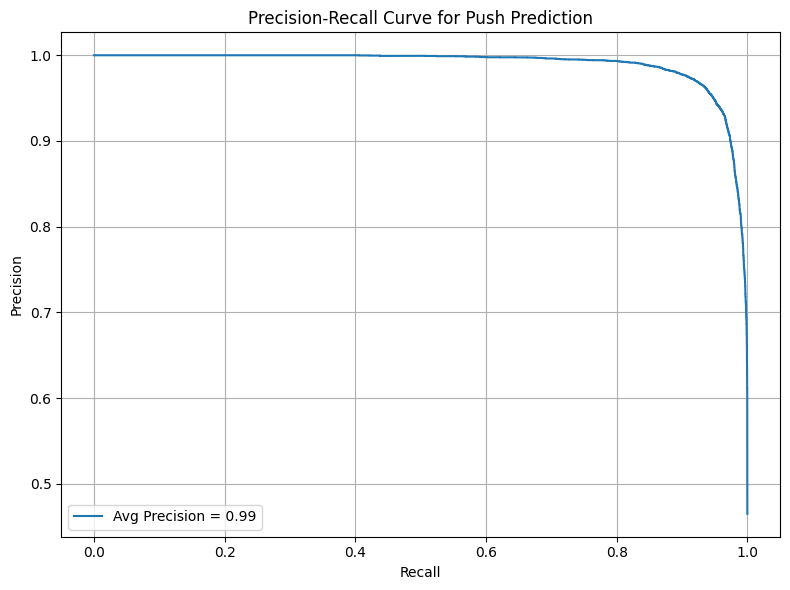

In [107]:
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
avg_precision = average_precision_score(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Avg Precision = {avg_precision:.2f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Push Prediction")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

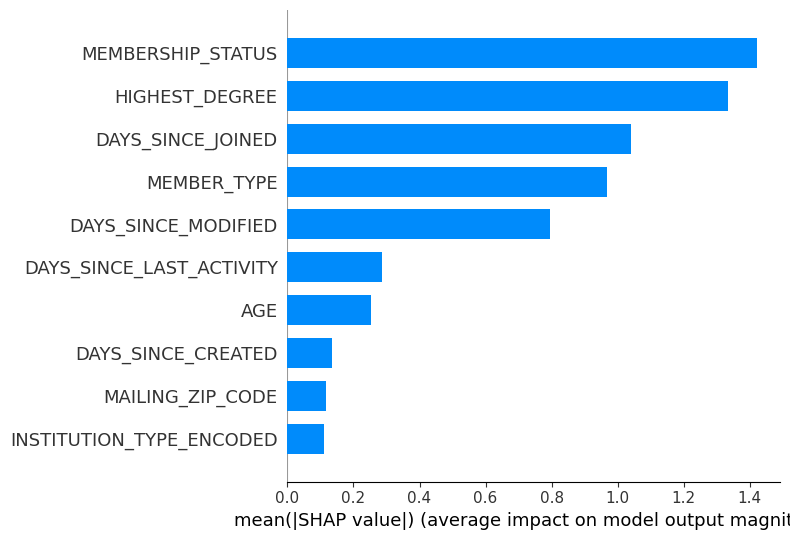

In [108]:
#Create a SHAP TreeExplainer for your XGBoost model
explainer = shap.TreeExplainer(model)

#Calculate SHAP values on a sample of your test set
shap_values = explainer.shap_values(X_test)

#Summary plot of global feature importance
shap.summary_plot(shap_values, X_test, max_display=10, plot_type="bar")
plt.show()

#### <p style="text-align: center;"> Churned </p>

Tune hyperparameters

In [94]:
#Drop original targets for training
X = df.drop(columns=['CHURNED', 'PUSHED'])
y = df['CHURNED'] 

#Handle categorical columns (XGBoost needs numeric input)
#X = pd.get_dummies(X, dummy_na=True)
for col in X.select_dtypes(include='object'):
    X[col] = X[col].astype('category').cat.codes

#Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

#Use actual class imbalance from training data
scale_pos_weight_val = (y_train == 0).sum() / (y_train == 1).sum()

#Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 5, 10],
    'gamma': [0, 1, 5]
}

#Set up the base model with fixed class weight
xgb_base = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight_val,
    n_jobs=-1,
    random_state=42
)

#Run randomized search
search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_grid,
    scoring='average_precision',  #optimizes area under the precision-recall curve
    n_iter=30,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

#Fit the search
search.fit(X_train, y_train)

#Retrieve the best model
best_model = search.best_estimator_

#Optional: Print the best hyperparameters
print("Best params:", search.best_params_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


c:\Users\maxwell.bicking\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:03:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best params: {'subsample': 0.8, 'n_estimators': 100, 'min_child_weight': 10, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 5, 'colsample_bytree': 1.0}


In [ ]:
y_prob = best_model.predict_proba(X_test)[:, 1]
y_pred_custom = (y_prob > 0.7).astype(int)

#Evaluation
print(classification_report(y_test, y_pred_custom))
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print(confusion_matrix(y_test, y_pred_custom))

              precision    recall  f1-score   support

           0       0.99      0.90      0.94     24436
           1       0.28      0.77      0.41      1236

    accuracy                           0.89     25672
   macro avg       0.63      0.83      0.68     25672
weighted avg       0.95      0.89      0.92     25672

ROC AUC: 0.9404961199747203
[[21985  2451]
 [  287   949]]


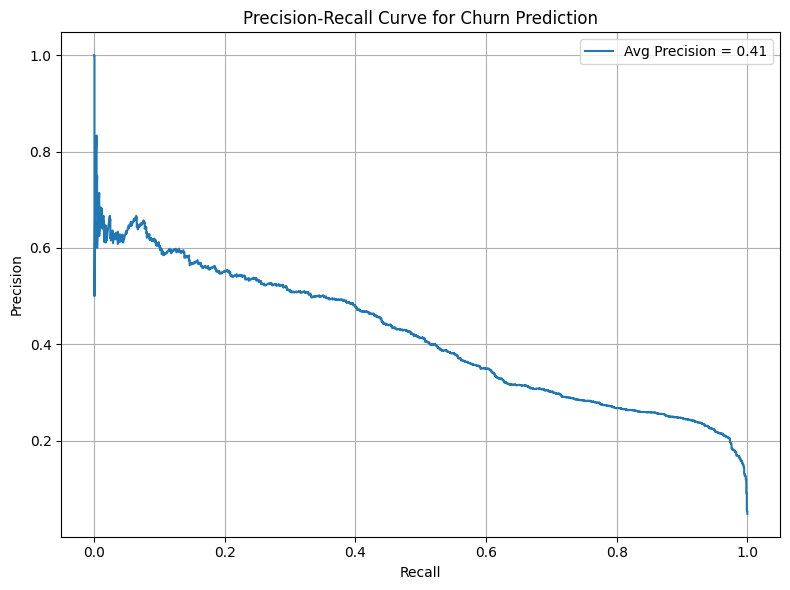

In [54]:
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
avg_precision = average_precision_score(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Avg Precision = {avg_precision:.2f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Churn Prediction")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Find best threshold for max F1

In [58]:
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

# Example: find the threshold with the best F1
f1_scores = 2 * (precision * recall) / (precision + recall)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"Best threshold for max F1: {best_threshold:.2f}, F1 = {f1_scores[best_idx]:.2f}")

Best threshold for max F1: 0.83, F1 = 0.45


#### <p style="text-align: center;"> Improved Churn Model Using Tuned Hyperparameters</p>

In [95]:
#-----------CHURNED-----------#

#Drop original targets for training
X = df.drop(columns=['CHURNED', 'PUSHED'])
y = df['CHURNED']  # use PUSHED_BINARY for push prediction

#Handle categorical columns (XGBoost needs numeric input)
#X = pd.get_dummies(X, dummy_na=True)
for col in X.select_dtypes(include='object'):
    X[col] = X[col].astype('category').cat.codes

#Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

#Train XGBoost model
model = xgb.XGBClassifier(
    tree_method="hist",
    eval_metric='logloss',
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
    subsample=0.8,
    n_estimators=100,
    min_child_weight=10,
    max_depth=10,
    learning_rate=0.1,
    gamma=5,
    colsample_bytree=1.0,
    n_jobs=-1,
    random_state=42
) #this yielded improvement in precision 0.23->0.28 and ROC AUC 0.92->0.94

model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=5,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=-1,
              num_parallel_tree=None, ...)

In [96]:
#Predictions
y_prob = model.predict_proba(X_test)[:, 1]
y_pred_custom = (y_prob > 0.6).astype(int)  #custom threshold

#Evaluation
print(classification_report(y_test, y_pred_custom))
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print(confusion_matrix(y_test, y_pred_custom))

              precision    recall  f1-score   support

           0       0.99      0.90      0.94     24437
           1       0.28      0.77      0.41      1235

    accuracy                           0.89     25672
   macro avg       0.63      0.83      0.68     25672
weighted avg       0.95      0.89      0.92     25672

ROC AUC: 0.9384912935667508
[[21991  2446]
 [  287   948]]


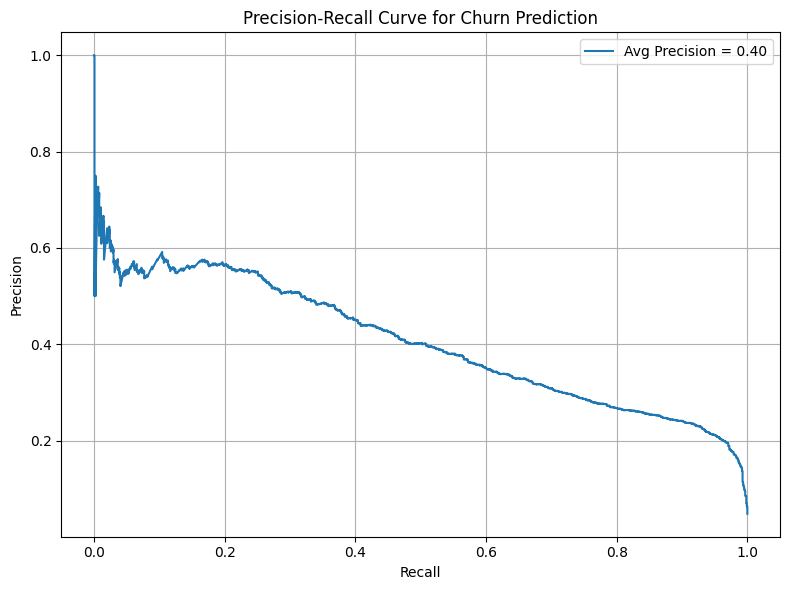

In [97]:
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
avg_precision = average_precision_score(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Avg Precision = {avg_precision:.2f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Churn Prediction")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

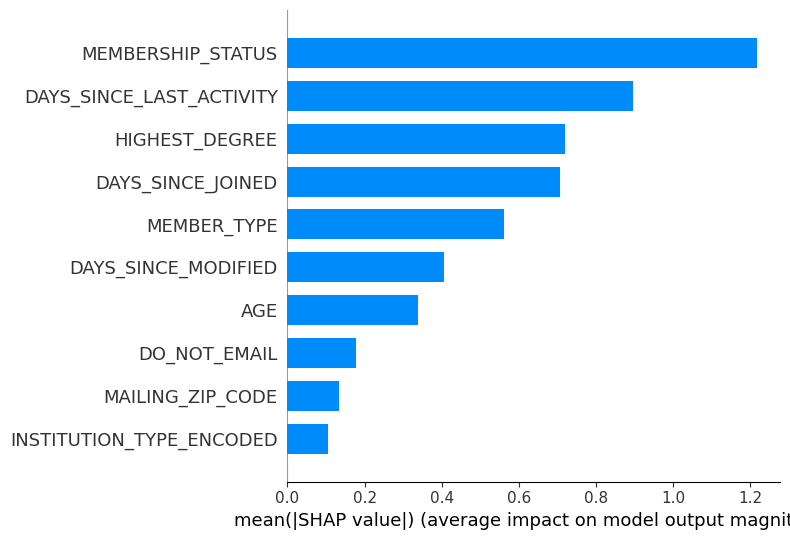

In [98]:
#Create a SHAP TreeExplainer for your XGBoost model
explainer = shap.TreeExplainer(model)

#Calculate SHAP values on a sample of your test set
shap_values = explainer.shap_values(X_test)

#Summary plot of global feature importance
shap.summary_plot(shap_values, X_test, max_display=10, plot_type="bar")
plt.show()